In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from models.transLOB import TransLOB
from utils.preprocessing import create_windows, generate_labels, normalize_features
from utils.training import train, validate
from utils.loader import LOBDataset

%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Downloading Data

In [4]:
destination = 'data/crypto/'
if not os.path.exists(destination) or len(os.listdir(destination)) == 0:
    path = kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")
    shutil.copytree(path, destination)

## Processing Data

In [19]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 32
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_10'
LABEL_ALPHA = 2e-5

LEARNING_RATE = 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY=1e-5

In [7]:
data_raw = pd.read_csv(DATA_PATH, index_col=0)

In [22]:
data_df = data_raw[:300000]
data_df['system_time'] = pd.to_datetime(data_df['system_time'])
data_df

/tmp/ipykernel_18190/2730328399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['system_time'] = pd.to_datetime(data_df['system_time'])


,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021-04-10 22:53:24.234644+00:00,59201.815,0.01,56.734080,784.727275,-8.445687e-08,-7.187280e-05,-0.000089,-0.000090,-0.000092,...,0.0,0.0,0.0,0.0,0.0,8.97,0.0,0.0,0.0,0.0
299996,2021-04-10 22:53:25.234644+00:00,59196.365,0.01,27.861364,0.000000,-8.446465e-08,-6.165919e-06,-0.000053,-0.000060,-0.000176,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
299997,2021-04-10 22:53:26.234644+00:00,59196.365,0.01,47.755488,0.000000,-8.446465e-08,-6.165919e-06,-0.000060,-0.000073,-0.000160,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
299998,2021-04-10 22:53:27.234644+00:00,59196.365,0.01,0.000000,0.000000,-8.446465e-08,-6.165919e-06,-0.000060,-0.000176,-0.000260,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [16]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [f"{side}_distance_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
notional_features = [f"{side}_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
cancel_notional_features = [f"{side}_cancel_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
limit_notional_features = [f"{side}_limit_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]
market_notional_features = [f"{side}_market_notional_{level}" for side in ['bids', 'asks'] for level in range(LEVELS)]

In [23]:
data_df = data_df[meta_features + distance_features + notional_features]
data_df = generate_labels(data_df, HORIZONS, alpha=LABEL_ALPHA)
data_df = normalize_features(data_df)
data_df

<string>:9: RuntimeWarning: divide by zero encountered in divide


,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_notional_5,asks_notional_6,asks_notional_7,asks_notional_8,asks_notional_9,y_10,y_20,y_30,y_50,y_100
0,2021-04-07 11:49:22.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.137565,-0.142660,-0.166498,-0.178503,-0.212531,...,-0.039704,0.609905,-0.387884,0.341698,1.105326,0,0,0,0,0
1,2021-04-07 11:49:23.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.137339,-0.142434,-0.166272,-0.178277,-0.212306,...,-0.039895,0.608994,-0.387898,0.341282,1.103300,0,0,0,0,0
2,2021-04-07 11:49:24.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.137113,-0.142209,-0.166046,-0.178052,-0.212081,...,-0.040087,0.608084,-0.387911,0.340867,1.101278,0,0,0,0,0
3,2021-04-07 11:49:25.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.136887,-0.141983,-0.165821,-0.177826,-0.211855,...,-0.040279,0.607175,-0.387925,0.340451,1.099261,0,0,0,0,0
4,2021-04-07 11:49:26.122161+00:00,56009.740,12.78,1286.296107,4761.473636,-0.136661,-0.141757,-0.165595,-0.177601,-0.211630,...,-0.040470,0.606266,-0.387939,0.340036,1.097249,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298995,2021-04-10 22:53:24.234644+00:00,59201.815,0.01,56.734080,784.727275,-1.567005,-1.681070,-1.708177,-1.710056,-1.713276,...,-0.516851,-0.392285,-0.311144,1.659914,6.434801,1,1,1,1,1
298996,2021-04-10 22:53:25.234644+00:00,59196.365,0.01,27.861364,0.000000,-1.708863,-1.718511,-1.792748,-1.804540,-1.987854,...,5.434129,-0.490636,1.116358,6.211055,2.909814,1,1,1,1,1
298997,2021-04-10 22:53:26.234644+00:00,59196.365,0.01,47.755488,0.000000,-1.704430,-1.714064,-1.799973,-1.819510,-1.957605,...,5.351238,1.150953,1.116302,6.088877,-0.547196,1,1,1,1,1
298998,2021-04-10 22:53:27.234644+00:00,59196.365,0.01,0.000000,0.000000,-1.700019,-1.709641,-1.795429,-1.978231,-2.111859,...,1.340732,5.249008,0.329949,-0.218818,0.573581,1,1,1,1,1


## EDA

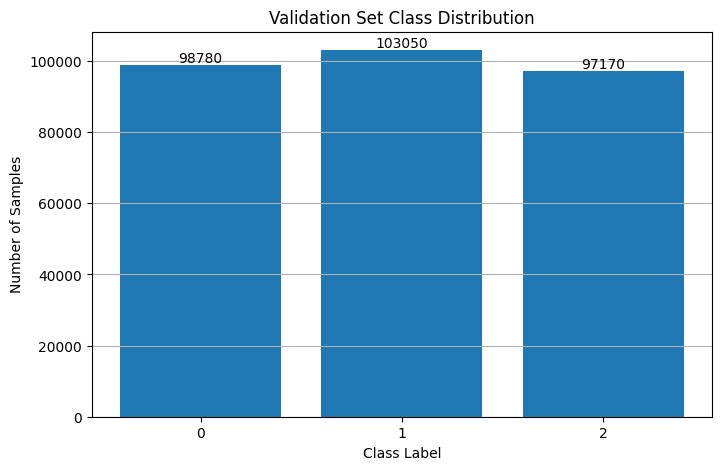

In [24]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Validation Set Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()


In [25]:
feature_cols = [col for col in data_df.columns if col not in meta_features and not col.startswith('y_')]

X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((299000, 40), (299000,))

In [26]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(298900, 100, 40)

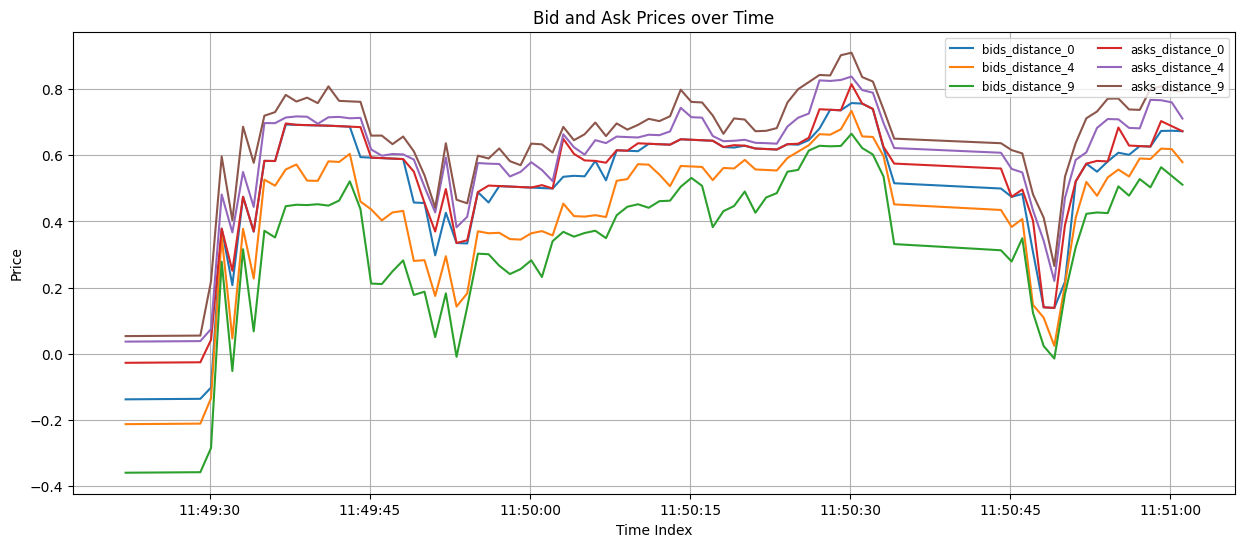

In [27]:
bid_price_cols = ['bids_distance_0','bids_distance_4','bids_distance_9']
ask_price_cols = ['asks_distance_0','asks_distance_4','asks_distance_9']

plot_range = 100

plt.figure(figsize=(15, 6))

# Plot bids
for col in bid_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='blue', alpha=0.5)

# Plot asks
for col in ask_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='red', alpha=0.5)

plt.title('Bid and Ask Prices over Time')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid()
plt.show()

In [13]:
# distances = data_df[distance_features].melt(var_name="distance_level", value_name="distance_value")
# notionals = data_df[notional_features].melt(var_name="notional_level", value_name="notional_value")

# combined = pd.DataFrame({
#     "distance": distances["distance_value"],
#     "notional": notionals["notional_value"]
# })

# plt.figure(figsize=(14, 6))
# plt.scatter(combined["distance"], combined["notional"], alpha=0.3)
# plt.xlabel('Distance from Midprice')
# plt.ylabel('Notional Volume')
# plt.title('Price Distance vs Notional Volume')
# plt.grid(True)
# plt.show()

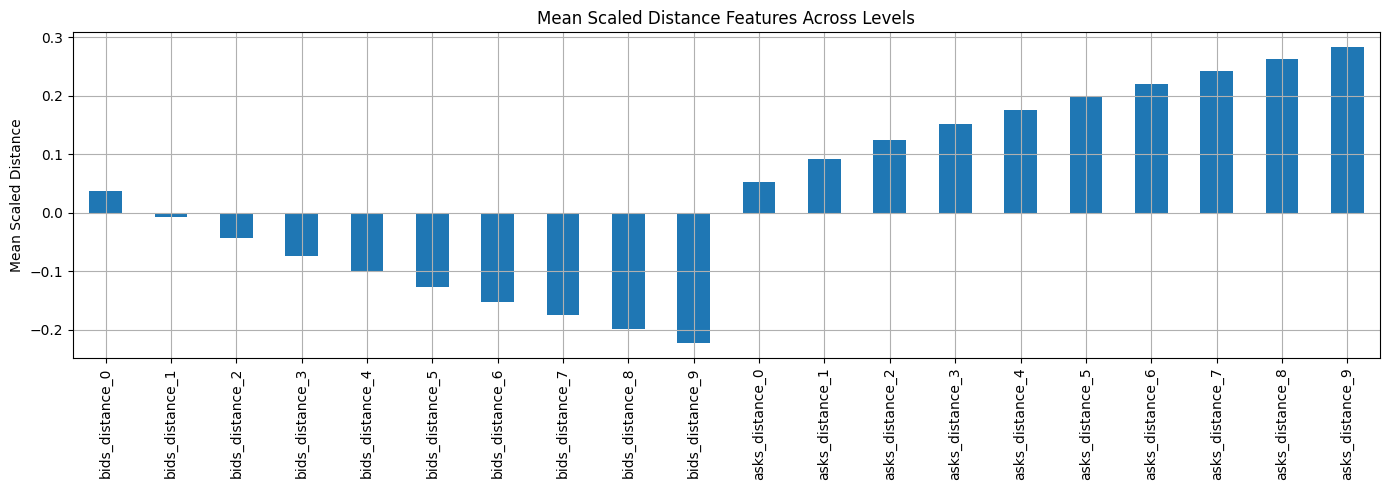

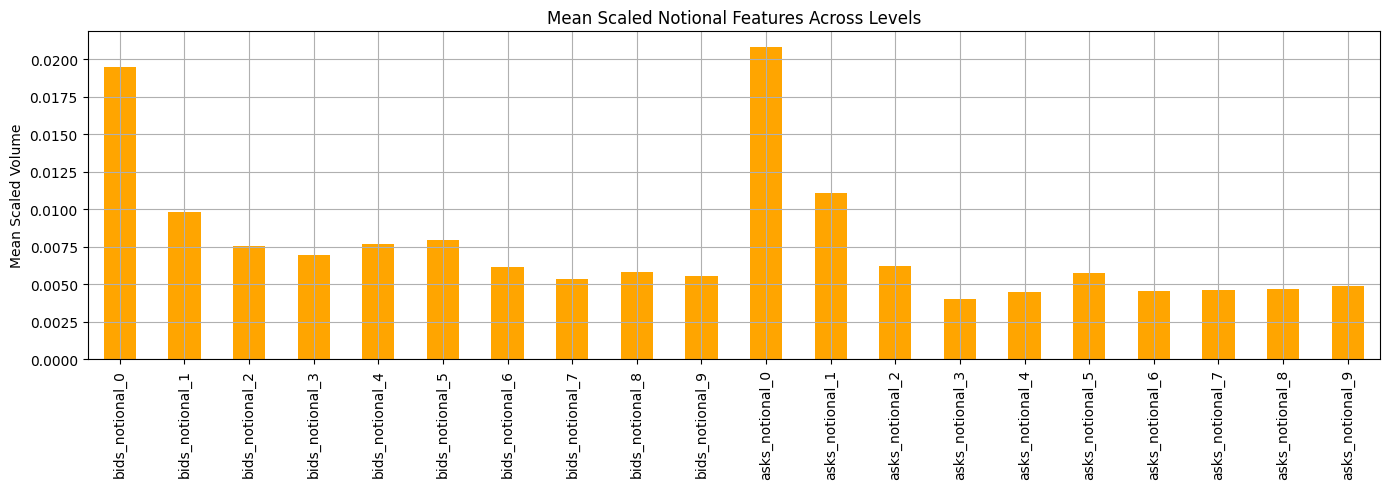

In [28]:
# Plot mean distance values across levels
plt.figure(figsize=(14, 5))
data_df[distance_features].mean().plot(kind='bar', title='Mean Scaled Distance Features Across Levels')
plt.ylabel('Mean Scaled Distance')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
data_df[notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

## TransLOB

In [29]:
train_size = int(0.7 * len(X_windows))
val_size = int(0.2 * len(X_windows))

X_train, y_train = X_windows[:train_size], y_labels[:train_size]
X_val, y_val = X_windows[train_size:train_size+val_size], y_labels[train_size:train_size+val_size]
X_test, y_test = X_windows[train_size+val_size:], y_labels[train_size+val_size:]

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (209230, 100, 40), (209230,)
Validation shape: (59780, 100, 40), (59780,)
Test shape: (29890, 100, 40), (29890,)


In [30]:
train_dataset = LOBDataset(X_train, y_train)
val_dataset = LOBDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
model = TransLOB(
    num_features=len(feature_cols),
    num_classes=3,
    hidden_channels=14,
    d_model=15,
    num_heads=3,
    num_transformer_blocks=2
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(ADAM_B1, ADAM_B2), weight_decay=WEIGHT_DECAY)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 15
best_val_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './outputs/transLOB/best_model.pth')
        print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")

[Batch 0/3270] Train Loss: 1.1151 | Train Accuracy: 0.3594
[Batch 500/3270] Train Loss: 1.1070 | Train Accuracy: 0.2969
[Batch 1000/3270] Train Loss: 1.0808 | Train Accuracy: 0.4219
[Batch 1500/3270] Train Loss: 1.0351 | Train Accuracy: 0.4375
[Batch 2000/3270] Train Loss: 1.0865 | Train Accuracy: 0.3594
[Batch 2500/3270] Train Loss: 1.0747 | Train Accuracy: 0.4219
[Batch 3000/3270] Train Loss: 1.0155 | Train Accuracy: 0.4531
Epoch 1/15: Train Loss 1.0728 | Train Acc 0.3960 | Val Loss 1.0758 | Val Acc 0.3966
✅ Saved best model at epoch 1 with Val Acc 0.3966
[Batch 0/3270] Train Loss: 1.0872 | Train Accuracy: 0.3438
[Batch 500/3270] Train Loss: 1.1030 | Train Accuracy: 0.3438
[Batch 1000/3270] Train Loss: 1.0472 | Train Accuracy: 0.3750
[Batch 1500/3270] Train Loss: 1.0195 | Train Accuracy: 0.5156
[Batch 2000/3270] Train Loss: 0.9474 | Train Accuracy: 0.5781
[Batch 2500/3270] Train Loss: 1.0469 | Train Accuracy: 0.4844
[Batch 3000/3270] Train Loss: 1.0671 | Train Accuracy: 0.3906
Epoch 

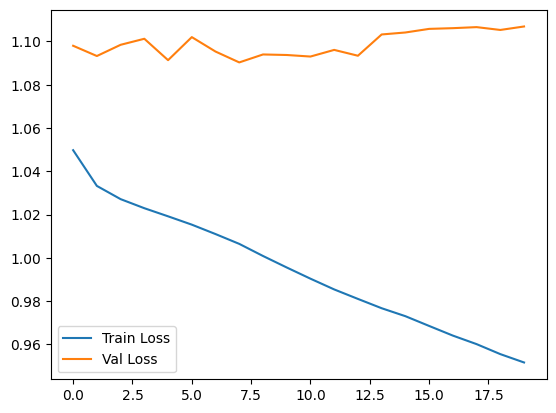

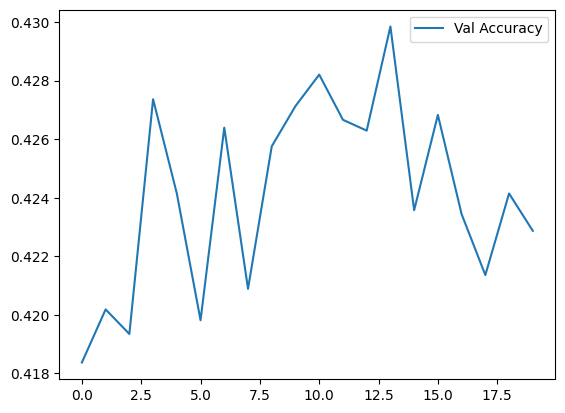

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

In [21]:
model.eval()

X_sample_batch, y_true_batch = next(iter(val_loader))
X_sample_batch, y_true_batch = X_sample_batch.to(device), y_true_batch.to(device)

with torch.no_grad():
    outputs = model(X_sample_batch)
    _, y_pred_batch = outputs.max(1)

# Move back to CPU for easy viewing
y_true_batch = y_true_batch.cpu().numpy()
y_pred_batch = y_pred_batch.cpu().numpy()

# Compare true vs predicted
for i in range(30):  # first 10 examples
    print(f"Sample {i}: True label = {y_true_batch[i]}, Predicted = {y_pred_batch[i]}")


Sample 0: True label = 0, Predicted = 2
Sample 1: True label = 0, Predicted = 2
Sample 2: True label = 0, Predicted = 2
Sample 3: True label = 0, Predicted = 2
Sample 4: True label = 0, Predicted = 2
Sample 5: True label = 0, Predicted = 2
Sample 6: True label = 0, Predicted = 2
Sample 7: True label = 0, Predicted = 2
Sample 8: True label = 0, Predicted = 2
Sample 9: True label = 0, Predicted = 2
Sample 10: True label = 0, Predicted = 2
Sample 11: True label = 0, Predicted = 2
Sample 12: True label = 0, Predicted = 2
Sample 13: True label = 0, Predicted = 2
Sample 14: True label = 0, Predicted = 2
Sample 15: True label = 0, Predicted = 2
Sample 16: True label = 0, Predicted = 2
Sample 17: True label = 0, Predicted = 2
Sample 18: True label = 0, Predicted = 2
Sample 19: True label = 0, Predicted = 2
Sample 20: True label = 0, Predicted = 0
Sample 21: True label = 0, Predicted = 0
Sample 22: True label = 2, Predicted = 0
Sample 23: True label = 2, Predicted = 0
Sample 24: True label = 2,

In [22]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

manual_val_acc = correct / total
print(f"Manual Validation Accuracy: {manual_val_acc:.4f}")

Manual Validation Accuracy: 0.4229


In [ ]:
# model.eval()
# with torch.no_grad():
#     for X_batch, y_batch in val_loader:
#         X_batch = X_batch.to(device)

#         outputs, attn_weights = model(X_batch, return_attention=True)

#         # Save attn_weights somewhere
#         final_attention = attn_weights
#         break  # (Optional) only save first batch

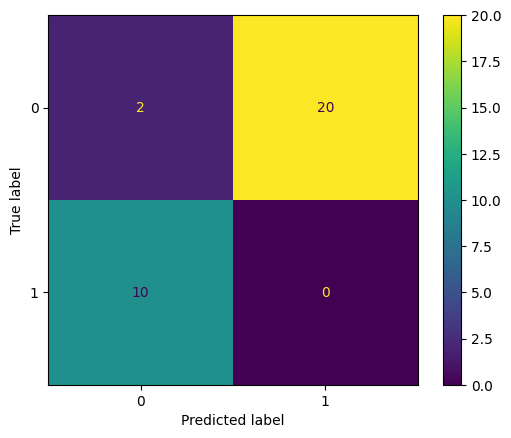

In [23]:
cm = confusion_matrix(y_true_batch, y_pred_batch)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

{np.int64(0): np.int64(46170), np.int64(1): np.int64(25061), np.int64(2): np.int64(47889)}


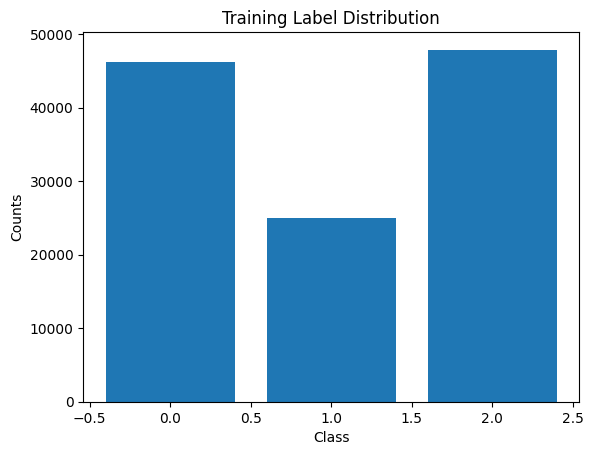

In [24]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

plt.bar(unique, counts)
plt.title("Training Label Distribution")
plt.xlabel("Class")
plt.ylabel("Counts")
plt.show()